<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import time
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import catboost as cat
from lightgbm import LGBMRegressor
import lightgbm as lgb
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True) # Отсортируем данные по индексу

In [4]:
df = df.resample('1H').sum() # Сгруппируем данные по часам

In [5]:
df.head() # Посмотрим первые 5 строк

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
df.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [7]:
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

In [8]:
df.info(memory_usage='deep') #Выведем информацию о таблице

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
df.describe().T # выведем стат данные

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


### Вывод

<br> Данные подготовлены. В данных 2 столбца (дата и количество заказов) и 4416 строк. Данные представлены от 01.03.2018 до 31.08.2018.

## Анализ

<AxesSubplot:title={'center':'Количество заказов по дням'}, xlabel='datetime'>

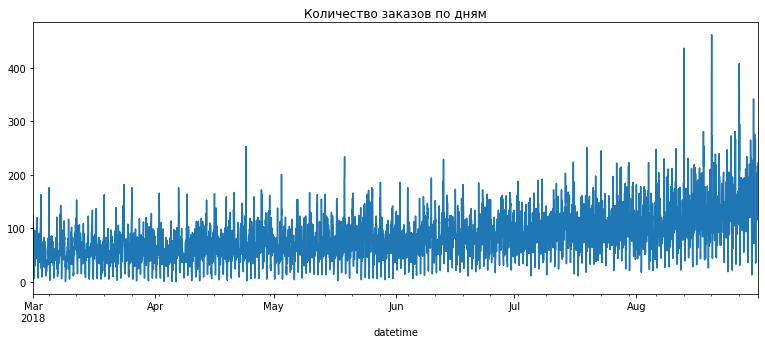

In [10]:
plt.figure(figsize=(13,5))
plt.title('Количество заказов по дням')
df['num_orders'].plot()

<div style="border:solid green 2px; padding: 10px">
    
Временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия.

In [11]:
# Создадим столбец со скользящим средним и окном 10.
df['rolling_mean']=df['num_orders'].rolling(window=10).mean()
#df['rolling_std']=df['num_orders'].rolling(window=10).std()
df=df.fillna(0)
#df['rolling_std']=df.rolling(window=4).mean()

<AxesSubplot:xlabel='datetime'>

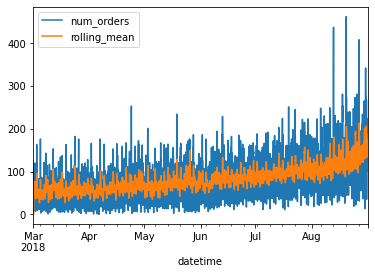

In [12]:
df.plot()

In [13]:
# Произвожу декомпозицию временного ряда, что увидеть тренд, сезонность и белый шум
decomposed = seasonal_decompose(df['num_orders'])

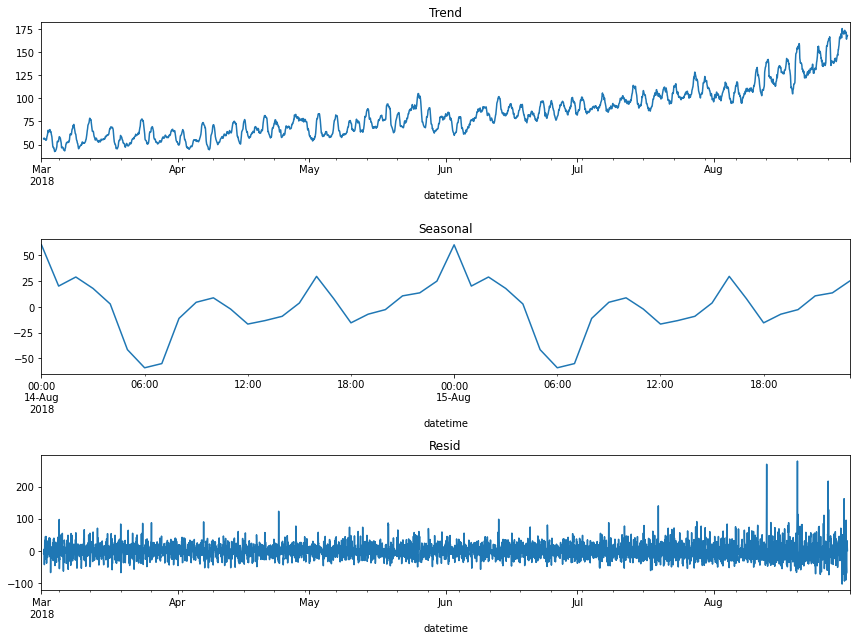

In [14]:
plt.figure(figsize=(12, 9))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

<div style="border:solid green 2px; padding: 10px">

На тренде можно увидеть, что количетсво заказов со временем увеличивается. По сезонности можно увидеть как меняется количество заказов в течении дня и наблюдать повторяемость этого на следующие дни. Быляй шум как и положенно со средним отклонением в райне 0.

### Вывод

<br>Проанализировали данные и выявили, что временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия.
<br> Также выявили тренды и сезонность: Количество заказов со временем увеличивается, а в течении дня выявляются закономернности (рано утром заказов гораздо меньше чем поздно вечером). 

## Обучение

In [15]:
# Напишем функцию для создания признаков
def make_features(df, max_lag, rolling_sum_size):
    #calendar features
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    #lag feature
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    #rolling feature
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

In [16]:
df=df.drop('rolling_mean', axis = 1) # Удалим столбец со скользящим средним

In [17]:
make_features(df, 6, 1)

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [19]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

### LinearRegression

In [20]:
modelLR = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
paramLR = {'normalize' : [True]}
scoreLR = GridSearchCV(estimator=modelLR, cv=tscv , param_grid=paramLR, scoring = 'neg_root_mean_squared_error')
scoreLR.fit(train_features, train_target)
#print('LinearRegression RMSE on train', np.abs(scoreLR))
print('LinearRegression RMSE on train', np.abs(scoreLR.best_score_))

LinearRegression RMSE on train 31.530667069298072


### CatBoostRegressor

In [21]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)

In [22]:
modelCat = CatBoostRegressor( random_state = 42)

In [23]:
%%time
param_search = {'depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'iterations' : [1000, 2000],
                'verbose' : [100]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchCat = GridSearchCV(estimator=modelCat, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchCat.fit(train_features, train_target)
print('CatBoostRegressor RMSE on train', np.abs(gsearchCat.best_score_))
print(gsearchCat.best_params_)

0:	learn: 29.2843234	total: 46.9ms	remaining: 46.8s
100:	learn: 19.0494991	total: 82.2ms	remaining: 732ms
200:	learn: 17.3976357	total: 113ms	remaining: 449ms
300:	learn: 16.3440228	total: 143ms	remaining: 331ms
400:	learn: 15.6388777	total: 186ms	remaining: 277ms
500:	learn: 14.9882024	total: 220ms	remaining: 219ms
600:	learn: 14.2641291	total: 268ms	remaining: 178ms
700:	learn: 13.6260466	total: 301ms	remaining: 129ms
800:	learn: 13.0657413	total: 333ms	remaining: 82.7ms
900:	learn: 12.5515508	total: 370ms	remaining: 40.7ms
999:	learn: 12.0783549	total: 402ms	remaining: 0us
0:	learn: 29.9599824	total: 673us	remaining: 673ms
100:	learn: 20.9115108	total: 45.8ms	remaining: 408ms
200:	learn: 19.3680478	total: 98.7ms	remaining: 392ms
300:	learn: 18.4831833	total: 144ms	remaining: 335ms
400:	learn: 17.8290633	total: 188ms	remaining: 280ms
500:	learn: 17.2410843	total: 243ms	remaining: 242ms
600:	learn: 16.7129505	total: 287ms	remaining: 191ms
700:	learn: 16.2050429	total: 331ms	remaining:

### LGBMRegressor

In [24]:
%%time
modelLight = LGBMRegressor(random_state = 42)
param_search = {'max_depth' : [1,3],
                'learning_rate' : [0.1, 0.2],
                'n_estimators' : [50,100],
                'verbose' : [100]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchLight = GridSearchCV(estimator=modelLight, cv=tscv,
                        param_grid=param_search,scoring = 'neg_root_mean_squared_error')
gsearchLight.fit(train_features, train_target)
print('LGBMRegressor RMSE on train', np.abs(gsearchLight.best_score_))
print(gsearchLight.best_params_)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018552
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.000374 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 10
[LightGBM] [Info] Start training from score 56.930618
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 a

### Вывод

<br>LinearRegression RMSE on train 31.530667069298072
<br>CatBoostRegressor RMSE on train 25.214454821087802
<br>LGBMRegressor RMSE on train 25.622128030730504

## Тестирование

### LinearRegression

In [25]:
modelLR = LinearRegression(normalize = True)
modelLR.fit(train_features, train_target)
predictionLR = modelLR.predict(test_features)
print('LinearRegression RMSE on test', mean_squared_error(test_target,predictionLR)**0.5)

LinearRegression RMSE on test 53.281223338496275


### CatBoostRegressor

In [26]:
modelCat = CatBoostRegressor(depth = 6, iterations = 2000, learning_rate = 0.03, loss_function = 'RMSE')
modelCat.fit(train_dataset, eval_set = test_dataset, plot = True)
print('CatBoostRegressor RMSE on test', mean_squared_error(test_target, modelCat.predict(test_features))**0.5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 38.1199555	test: 83.8871122	best: 83.8871122 (0)	total: 2.23ms	remaining: 4.46s
1:	learn: 37.6368837	test: 83.2236396	best: 83.2236396 (1)	total: 4.3ms	remaining: 4.29s
2:	learn: 37.1086068	test: 82.3929271	best: 82.3929271 (2)	total: 6.42ms	remaining: 4.27s
3:	learn: 36.6414545	test: 81.6669632	best: 81.6669632 (3)	total: 8.27ms	remaining: 4.13s
4:	learn: 36.1752694	test: 80.9775186	best: 80.9775186 (4)	total: 10.3ms	remaining: 4.1s
5:	learn: 35.6847407	test: 80.2850186	best: 80.2850186 (5)	total: 12.4ms	remaining: 4.11s
6:	learn: 35.2134569	test: 79.5859167	best: 79.5859167 (6)	total: 14.2ms	remaining: 4.04s
7:	learn: 34.8166880	test: 78.8712386	best: 78.8712386 (7)	total: 16ms	remaining: 4s
8:	learn: 34.4285606	test: 78.2662962	best: 78.2662962 (8)	total: 17.9ms	remaining: 3.95s
9:	learn: 34.0547675	test: 77.6758415	best: 77.6758415 (9)	total: 19.7ms	remaining: 3.91s
10:	learn: 33.6836418	test: 77.1576924	best: 77.1576924 (10)	total: 21.4ms	remaining: 3.87s
11:	learn: 33.3

### LGBMRegressor

In [27]:
modelLight = LGBMRegressor(max_depth = 3,n_estimators = 100, learning_rate = 0.2, random_state = 42)
modelLight.fit(train_features,train_target, eval_set = (test_features,test_target), eval_metric = 'RMSE')
print('LGBMRegressor RMSE on test', mean_squared_error(test_target, modelLight.predict(test_features))**0.5)

[1]	valid_0's rmse: 79.8228	valid_0's l2: 6371.67
[2]	valid_0's rmse: 76.645	valid_0's l2: 5874.45
[3]	valid_0's rmse: 73.6639	valid_0's l2: 5426.37
[4]	valid_0's rmse: 70.7681	valid_0's l2: 5008.13
[5]	valid_0's rmse: 67.866	valid_0's l2: 4605.79
[6]	valid_0's rmse: 64.9646	valid_0's l2: 4220.41
[7]	valid_0's rmse: 63.308	valid_0's l2: 4007.9
[8]	valid_0's rmse: 61.4002	valid_0's l2: 3769.99
[9]	valid_0's rmse: 60.3684	valid_0's l2: 3644.34
[10]	valid_0's rmse: 59.2241	valid_0's l2: 3507.5
[11]	valid_0's rmse: 57.955	valid_0's l2: 3358.78
[12]	valid_0's rmse: 56.6955	valid_0's l2: 3214.38
[13]	valid_0's rmse: 55.7971	valid_0's l2: 3113.32
[14]	valid_0's rmse: 55.1663	valid_0's l2: 3043.32
[15]	valid_0's rmse: 52.4098	valid_0's l2: 2746.79
[16]	valid_0's rmse: 51.5481	valid_0's l2: 2657.2
[17]	valid_0's rmse: 51.2732	valid_0's l2: 2628.94
[18]	valid_0's rmse: 51.0761	valid_0's l2: 2608.77
[19]	valid_0's rmse: 50.1239	valid_0's l2: 2512.41
[20]	valid_0's rmse: 49.7135	valid_0's l2: 2471

In [28]:
LightPred = modelLight.predict(test_features)
CatPred = modelCat.predict(test_features)

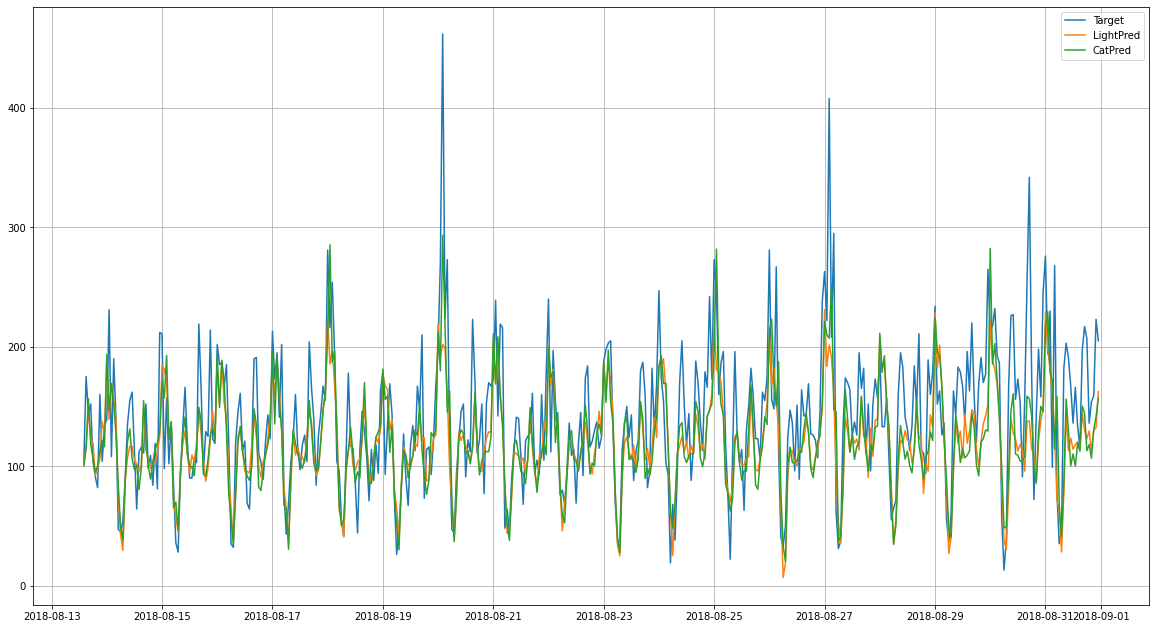

In [29]:
frame = {'Target':test_target, 'LightPred':LightPred, 'CatPred':CatPred}
result = pd.DataFrame(frame) 
plt.figure(figsize=(20,11))
plt.plot(result)
plt.legend(['Target','LightPred' ,'CatPred'])
plt.grid(True)
plt.show;

### Вывод

<br>LinearRegression RMSE on test 53.05143435320525
<br>CatBoostRegressor RMSE on test 44.145530863595724
<br>LGBMRegressor RMSE on test 44.47651182081992

## Общий вывод

<div style="border:solid green 5px; padding: 20px">
    
**<font color="green">Подготовка данных</font>**    
<br> Данные подготовлены. В данных 2 столбца (дата и количество заказов) и 4416 строк. Данные представлены от 01.03.2018 до 31.08.2018.
        
**<font color="green">Анализ данных</font>** 
<br>Проанализировали данные и выявили, что временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия.
<br>Также выявили тренды и сезонность: Количество заказов со временем увеличивается, а в течении дня выявляются закономернности (рано утром заказов гораздо меньше чем поздно вечером). 
    
**<font color="green">Обучение </font>** 
<br>LinearRegression RMSE on train 31.530667069298072
<br>CatBoostRegressor RMSE on train 25.214454821087802
<br>LGBMRegressor RMSE on train 25.622128030730504
    
**<font color="green">Тестирование</font>**
<br>LinearRegression RMSE on test 53.05143435320525
<br>CatBoostRegressor RMSE on test 44.145530863595724
<br>LGBMRegressor RMSE on test 44.47651182081992
    
**<font color="green">Общий вывод</font>**    
<br>Обучили 3 модели которые на тестовой выборке показали RMSE меньше 48. Бустинговые модели справляются гораздо лучше. На графике видно что модели неплохо справляются и даже могут предсказывать резкие скачки, но крайне редко и в основном нижние скачки. Да и в целом модели имеют тенденцию предсказывать ниже target.
<br> Немного смутила разница показателей RMSE на train и test, но возможно это специфика временных рядов(или специального вида кросс валидации для временных рядов)    